In [1]:
%matplotlib inline
import numpy as np
import scipy.integrate as ode
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display,HTML
import matplotlib.cm as cmx 
import matplotlib.colors as colors 
mpl.style.use('seaborn-dark')
plt.rc("figure",figsize=(16,10))


## Basic functions of the model

In [2]:
def fitness(A,mu=1):
    """Computation of the fitness of the reducted model.
    A is the matrix of interaction and mu is the ratio I/II
    """
    n=len(A)
    return np.array(mu*(A.T-A)+A.T-np.matrix(np.ones((n,1)))*np.matrix(np.diagonal(A)))
def theta(R0,k,beta=1):
    T=1-1/R0
    I=(R0-1)/(R0+R0*k*(R0-1))
    D=T-I
    return beta*I*D*T/(2*T**2-I*D) 
def thetamu(R0,k,beta=1):
    return theta(R0,k,beta=beta)/(R0-1)*k
def slowdyn(T,z,Lambda=None,D=1):
    n=len(z)
    if type(z) is list:
        z=np.array(z)
    if Lambda is None : Lambda=np.array([[]])
    if type(Lambda) is list : Lambda=np.array(Lambda)
    if np.shape(Lambda)!=(len(z),len(z)):
        print('Attention mauvais lambda. Remplacement par une valeur par défaut')
        Lambda=np.ones((len(z),len(z)))
        Lambda=Lambda-np.diag(np.diag(Lambda))
    Q=np.dot(z.T,np.dot(Lambda,z))
    L=np.dot(Lambda,z)
    #D*np.array([max(zi,10**-17) for zi in z])*(L-Q)
    return D*z*(L-Q)

def traject(T,X0,fit,D=1,isdense=True):
    """kwargs=[A,mu] or kwargs=[Lambda]"""

    if type(X0) is list: X0=np.array(X0)
    if (X0<0).any() : 
        print('negativ entry')
        return None
    if (X0==0).all() : 
        print('no positiv entry')
        return  None
    X0=X0/np.sum(X0)
    def f_eval(t,X):
        Z=slowdyn(t,X,Lambda=fit,D=D)[:-1]
        return np.concatenate((Z,-np.array([sum(Z)])))
    resultat = ode.solve_ivp(fun=f_eval,
                             t_span=(0, T), 
                             y0=X0,
                             dense_output=isdense
                             #t_eval=np.arange(0,T,0.1),
                            )
    return resultat

# Functions for computing the dynamics

In [3]:
def simu(T=100,mu=None,A=None,fit=None,n=3,z0=None,T_threshold=None,V_threshold=10**-4,**kwargs):
    """Compute the dynamics for a n strain system.
    Input are :
    -T the final time 
    -mu the ratio I/D=1/(k(R0-1))
    -A the array of rescalled interactions.  A is automatiquely renormalised such that the euclidan norm is ||A||=1
    -fit the matrix of fitness (usefull if neither mu nor A is given).
    -n the number of species (usefull is neither mu nor A nor fit is given)
    If mu and A are given, the fitness is computed by the function fitness.
    If mu is given and not A, then A is generated randomly using a uniform distribution between -1 and 1
    If A is given and not mu then mu is generated randomly using a uniform distribution between 0 and 10
    If none of mu, A or fit are  given, then mu=1 and A  is generated by using a uniform distribution between -1 and 1.
    
    Additional arguments are 
    -z0 : the initial data
    -V_threshold : If z_i < threshold, then the strain i is considered to be not here
    -T_threshold: a percentage of T from which we compute the threshold. Default is 100%
    The output are mu, A, fit, the resultat of the dynamics and the number of coexistent species
    """
    if fit is  None:
        if mu is not None and A is  None :
            A=2*np.random.random((n,n))-1
        if  A is not None :
            if A is list:   A=np.array(A) ## Transform A in Array
            A=A/sum(sum(A**2)) ## renormalisation of A
            if mu is None : mu=10*np.random.random(1) ##generation of mu if needed
            n=len(A)
            fit=fitness(A=A,mu=mu)
        if mu is None and A is None and fit is None :
            mu=1
            A=2*np.random.random((n,n))-1
            A=A/sum(sum(A**2))
            fit=fitness(A=A,mu=mu)
    n=len(fit)
    if z0 is not None and len(z0)!=n : 
        print('Mistake in z0, the size len(z0)={}'.format(len(z0)),
                                                          r'$\ned$',
                                                          'n={}'.format(n),
                                                          'a random z0 is taken.') 
        z0=np.random.random(n)
    if z0 is None : z0=np.random.random(n)  ##Generation of the initial data
    ##Computation of the dynamics
    D=kwargs.pop('D',1)
    isdense=kwargs.pop('isdense',True)
    resultat=traject(T=T,X0=z0,fit=fit,D=D,isdense=isdense)
    if T_threshold is None : nc=len(resultat.y[:,-1][resultat.y[:,-1]>V_threshold])
    
    else :  
            Tstart=T*T_threshold
            ind_threshold=np.int(np.min(np.arange(0,len(resultat.t),1)[resultat.t>Tstart].tolist()+[T]))
            mean=np.mean(resultat.y[:,ind_threshold:],axis=1)
            nc=len(mean[mean>V_threshold])
    return mu, A,fit,resultat,nc
def dyna_q(fit,resultat,TT):
    YY=resultat.sol(TT)
    q=[]
    for k in range(len(YY.T)):
        z=np.array([list(YY[:,k])])
        q.append(sum(sum(fit*(z.T@z))))
        
    return q  

In [11]:
def dyna_env(n=10,itt=1,T=100,fit_type='rand',a=-1,b=1,fit=None,AX=None,xlab=True,title=True,distribution='unif',figure=False):
    if figure :
        if AX is None : fig,AX=plt.subplots(figsize=(25,5),ncols=3)
        ax0,ax1,ax2=AX
    Q=[]
    mq=0 
    mean=(a+b)/2
    sd=np.sqrt(((b-a)**2)/12)
    for _ in range(itt):
        if _>0 : fit=None
        if fit is not None : fit,n=fit,len(fit)
        else :
            if fit_type=='rand':
                if distribution == 'unif' : fit=(b-a)*np.random.random((n,n))+a
                else :fit=np.random.normal(mean,sd,(n,n))
                fit=fit-np.diag(np.diag(fit))
            elif fit_type=='line':
                if distribution =='unif' : Lfit=(b-a)*np.random.random((n,1))+a
                else : Lfit=np.random.normal(mean,sd,(n,1))
                fit=np.repeat(Lfit,n,axis=1)
                fit=fit-np.diag(np.diag(fit))
            elif fit_type=='col':
                if distribution =='unif' : Lfit=(b-a)*np.random.random((n,1))+a
                else : Lfit=np.random.normal(mean,sd,(n,1))
                fit=np.repeat(Lfit,n,axis=1).T
                fit=fit-np.diag(np.diag(fit))
            elif fit_type=='sym':
                if distribution =='unif' : fit=(b-a)*np.random.random((n,n))+a
                else : fit=np.random.normal(mean,sd,(n,n))
                fit=0.5*(fit+fit.T)
                fit=fit-np.diag(np.diag(fit))
            elif fit_type=='anti':
                if distribution =='unif' : fit=(b-a)*np.random.random((n,n))+a
                else : fit=np.random.normal(mean,sd,(n,n))
                fit=fit-fit.T
            elif fit_type=='antir':
                if distribution =='unif' : 
                    fit=(b-a)*np.random.random((n,n))+a
                    fit=fit-fit.T
                    fit=fit+(b-a)/10*np.random.random((n,n))
                else : 
                    fit=np.random.normal(mean,sd,(n,n)) 
                    fit=fit-fit.T
                    fit=fit+(b-a)/10*np.random.normal(0,1,(n,n))

        mu, A,fit,resultat,nc=simu(T=T,fit=fit)
        TT= np.arange(0,T,0.01)
        q=dyna_q(fit,resultat,TT)
        if (np.abs(q)<5).all():
            Q.append(q)
            ##ax0
            if figure:
                if _==0  :
                    _,maps,cbarb=matshow(fit,ax=ax0,barun=True,a=a,b=b)
                    cbarb.set_ticks([-1,0,1])
                    cbarb.set_ticklabels(['-1','0','1'])
                    cbarb.ax.tick_params(labelsize=20)

                    if title : ax0.set_title('Fitness '+r'$\Lambda$',fontsize=25)
                    if xlab : ax0.set_xlabel(r'Resident $j$',fontsize=30)
                    ax0.set_ylabel(r'Invader $i$',fontsize=30)
                    #ax0.yaxis.set_label_position('right')
                    ax1.set_yticks(np.linspace(0,1,5))
                    ax1.plot(TT,resultat.sol(TT).T,lw=5)
                    ax1.set_yticklabels([f'{k:1.1f}' for k in np.linspace(0,1,5)],fontsize=20)
                    ax1.set_ylim([0,1])
                    ax1.set_xlim([0,T])
                    ax1.set_xticks(np.linspace(0,T,5))
                    ax1.set_xticklabels([f'{k:3.0f}' for k in np.linspace(0,T,5)],fontsize=20)
                    if xlab : ax1.set_xlabel('Time '+r'$(\tau=\varepsilon t)$',fontsize=30)
                    ax1.set_ylabel(r'$z_i(\tau)$',fontsize=30)
                    if title : ax1.set_title('Strain frequencies',fontsize=25)
                    ##ax2
                    mq=max(-min(q),max(q))
                    ax2.plot(2*TT-T/2,0*TT,'-k',lw=1)
                    ax2.plot(TT,q,lw=5,color='b')
                    ax2.set_xticks(np.linspace(0,T,5))
                    ax2.set_xticklabels([f'{k:3.0f}' for k in np.linspace(0,T,5)],fontsize=20)
                    if xlab :  ax2.set_xlabel('Time '+r'$(\tau=\varepsilon t)$',fontsize=30)
                    ax2.set_ylabel(r'$Q(\tau)$',fontsize=30)
                    if title : ax2.set_title('Environment dynamics',fontsize=25)
                    ax2.yaxis.set_ticks_position('right')
                    ax2.set_xlim([0,T])
                ax2.plot(TT,q,lw=2,color='b',alpha=0.5)
                mq=max([mq,np.max(np.abs(q))])
                ax2.set_ylim([-mq-0.1,mq+0.1])
                ax2.set_yticks(np.linspace(-mq-0.1,mq+0.1,5))
                ax2.set_yticklabels([f'{k:1.2f}' for k in np.linspace(-mq-0.1,mq+0.1,5)],fontsize=20)
            #fin des figures
    Q=np.array(Q)
    if figure :    ax2.plot(TT,np.mean(Q,axis=0),color='red',lw=5)
    #print(f'{fit}')
    #plt.show()
    #print(f'{Q}')
    return fit,np.mean(Q,axis=0),np.sqrt(np.var(Q,axis=0))


# Function for Creating the figure

In [5]:
def matshow(A,ax=None,cmap='seismic',barun=False,a=-1,b=1, iflab=True):
    N=len(A)
    if ax is None :
        fig,ax=plt.subplots()
    if barun:    
        cmin,cmax=a,b
    else : cmin,cmax=np.min(A),np.max(A)
    maps=ax.imshow(A,cmap=cmap,vmin=a,vmax=b)
    #cbar=plt.colorbar(maps,ax=ax,shrink=1)
    #ax.set_xlabel(r'Resident $j$',fontsize=30)
    if iflab:
        ax.set_xticks(range(0,N))
        ax.set_xticklabels(range(1,N+1),fontsize=20)
        ax.set_yticks(range(0,N))
        ax.set_yticklabels(range(1,N+1),fontsize=20)
        cbar=plt.colorbar(maps,ax=ax,shrink=1)
    else :
        ax.set_xticks([])
        ax.set_yticks([])
        cbar=None
    ax.grid(False)
    return ax,maps,cbar  

In [6]:
def type_of_matrix(QQ,SSQ,Tmax=50):
    ####################################
    ##Generate the figure and subplots##
    ####################################
    fig,ax=plt.subplots(figsize=(10,10))
    G = mpl.gridspec.GridSpec(4, 7)
    fig.subplots_adjust(hspace=0.1,wspace=0.1)
    ax=plt.subplot(G[0:2,0:3])
    AAX=[]
    TITRES=['a.','b.','c.','d.','e.','f.']
    for k,subtitle in zip(range(6),TITRES):
        kc=k%3
        kl=k%2
        if k==1 : kl=0
        if k==4 : kl=1
        ax1=plt.subplot(G[kl,4+kc])
        ax1.set_title(subtitle)
        mat_fit=FFIT[k]
        matshow(mat_fit,ax=ax1,barun=False,a=-1,b=1,iflab=False)
        ax1.set_xlabel(r'Resident $j$',fontsize=15)
        if kc==0 : ax1.set_ylabel(r'Invader $i$',fontsize=15)
    ####################################
    ##########Labels and Colors#########
    ####################################
    labels=['a. Symmetric','b. Invader-driven',
            'c. Resident-driven', 'd. Antisymmetric',
            'e. Almost antisymmetric','f. Random']
    colors=['#1f77b4', '#ff7f0e', 
            '#2ca02c', '#d62728', 
            '#9467bd', '#8c564b']
    ####################################
    ##########Units of times############
    ####################################
    TT=np.arange(0,Tmax,0.01)
    ####################################
    #####Boundary of the variation#####
    ####################################
    dev=1
    low=[x-dev*y for x,y in zip(QQ,SSQ)]
    up=[x+dev*y for x,y in zip(QQ,SSQ)]
    ###################################
    #######Generating the figure#######
    ###################################

    for curve_low,curve_up,q,col,name in zip(low,up,QQ,colors,labels):
        ax.plot(TT,q,label=name,lw=5)
        ax.legend(fontsize=15,loc=(1.25,-0.35),ncol=2)
        ax.fill_between(TT,curve_low, curve_up, color=col,alpha=0.2)
        #ax.plot(TT,curve_low,color=col)
        #ax.plot(TT,curve_up,color=col)
        ax.set_xlim([0,50])   

    ax.set_xlabel('Time '+ r'$\tau$',fontsize=20)
    ax.set_ylabel(r'$Q(\tau)$',fontsize=20)
    ax.set_xticks(np.linspace(0,Tmax,5))
    ax.set_xticklabels([f'{k:3.0f}' for k in np.linspace(0,Tmax,5)],fontsize=20)
    ax.set_yticks([-0.2,0,0.2,0.4,0.6])
    ax.set_yticklabels([f'{k:1.2f}' for k in [-0.2,0,0.2,0.4,0.6]],fontsize=20);
    ax.text(75,0.8,r'Pairwise invasion matrix',fontsize=15,fontweight='bold' )
    #ax.set_title('Mean environment dynamics',fontsize=30)
    return None

# Generating the data #
## 1) Uniform distribution ##

In [7]:
TTYPE=['sym','line','col','anti','antir','rand']
Tmax=50
xlabsetup=[False]*(len(TTYPE)-1)+[True]
titlesetup=[True]+[False]*(len(TTYPE)-1)
FFIT,QQu,SSQu=[],[],[]
for typ in TTYPE:  
    #A[0].text(-7,5,nrow,fontsize=30,fontweight='bold')
    fit,qq,ssq=dyna_env(n=30,T=Tmax,itt=20,fit_type=typ,distribution='unif')
    FFIT.append(fit)
    QQu.append(qq)
    SSQu.append(ssq)

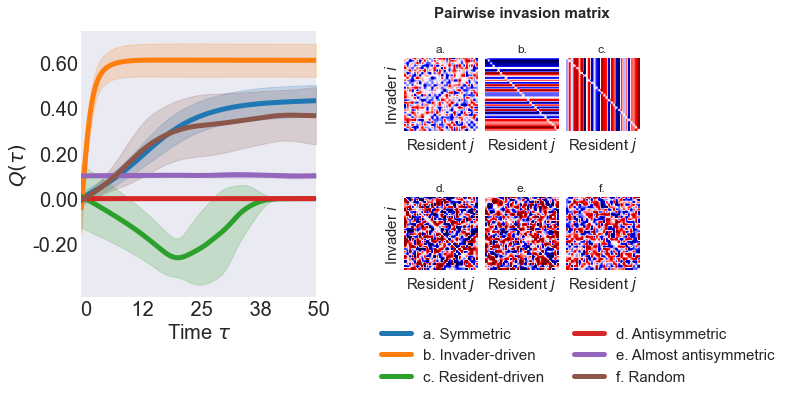

In [8]:
type_of_matrix(QQ=QQu,SSQ=SSQu,Tmax=50)

## 2) Normal distribution ##

In [12]:
TTYPE=['sym','line','col','anti','antir','rand']
Tmax=50
xlabsetup=[False]*(len(TTYPE)-1)+[True]
titlesetup=[True]+[False]*(len(TTYPE)-1)
FFIT,QQn,SSQn=[],[],[]
for typ in TTYPE:  
    #A[0].text(-7,5,nrow,fontsize=30,fontweight='bold')
    fit,qq,ssq=dyna_env(n=30,T=Tmax,itt=20,fit_type=typ,distribution='normal')
    FFIT.append(fit)
    QQn.append(qq)
    SSQn.append(ssq)

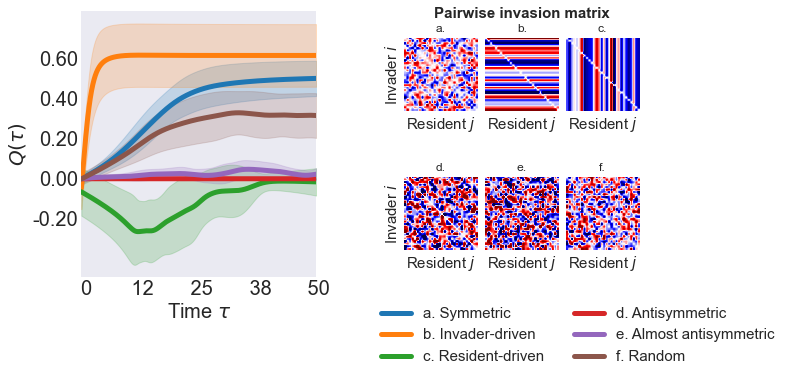

In [13]:
type_of_matrix(QQ=QQn,SSQ=SSQn,Tmax=50)